# Standard problem 5

## Problem specification

The sample is a thin film cuboid with dimensions:

- length $l_{x} = 100 \,\text{nm}$,
- width $l_{y} = 100 \,\text{nm}$, and
- thickness $l_{z} = 10 \,\text{nm}$.

The material parameters (similar to permalloy) are:

- exchange energy constant $A = 1.3 \times 10^{-11} \,\text{J/m}$,
- magnetisation saturation $M_\text{s} = 8 \times 10^{5} \,\text{A/m}$.

Dynamics parameters are: $\gamma_{0} = 2.211 \times 10^{5} \,\text{m}\,\text{A}^{-1}\,\text{s}^{-1}$ and Gilbert damping $\alpha=0.02$.

In the standard problem 5, the system is firstly relaxed at zero external magnetic field, starting from the vortex state. Secondly spin-polarised current is applied in the $x$ direction with $u_{x} = -72.35$ and $\beta=0.05$.

More detailed specification of Standard problem 5 can be found in Ref. 1.

## Simulation

In the first step, we import the required `discretisedfield` and `oommfc` modules.

In [1]:
import oommfc as oc
import discretisedfield as df
import micromagneticmodel as mm

Now, we can set all required geometry and material parameters.

In [2]:
# Geometry
lx = 100e-9  # x dimension of the sample(m)
ly = 100e-9  # y dimension of the sample (m)
lz = 10e-9  # sample thickness (m)
dx = dy = dz = 5e-9  #discretisation cell (nm)

# Material (permalloy) parameters
Ms = 8e5  # saturation magnetisation (A/m)
A = 1.3e-11  # exchange energy constant (J/m)

# Dynamics (LLG equation) parameters
gamma0 = 2.211e5  # gyromagnetic ratio (m/As)
alpha = 0.1  # Gilbert damping
ux = -72.35  # velocity in x direction
beta = 0.05  # non-adiabatic STT parameter

As usual, we create the system object with `stdprob5` name.

In [3]:
system = mm.System(name='stdprob5')

The mesh is created by providing two points `p1` and `p2` between which the mesh domain spans and the size of a discretisation cell. We choose the discretisation to be $(5, 5, 5) \,\text{nm}$.

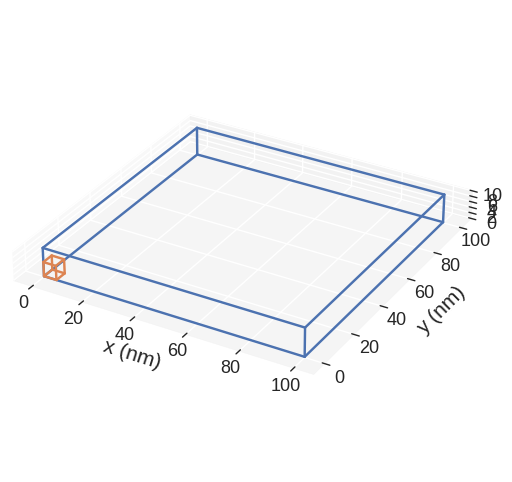

In [4]:
region = df.Region(p1=(0, 0, 0), p2=(lx, ly, lz))
mesh = df.Mesh(region=region, cell=(dx, dy, dz))
mesh.mpl()

**Hamiltonian:** In the second step, we define the system's Hamiltonian. In this standard problem, the Hamiltonian contains only exchange and demagnetisation energy terms. Please note that in the first simulation stage, there is no applied external magnetic field. Therefore, we do not add Zeeman energy term to the Hamiltonian.

In [5]:
system.energy = mm.Exchange(A=A) + mm.Demag()
system.energy

Exchange(A=1.3e-11) + Demag()

**Magnetisation:** We initialise the system using the initial magnetisation function.

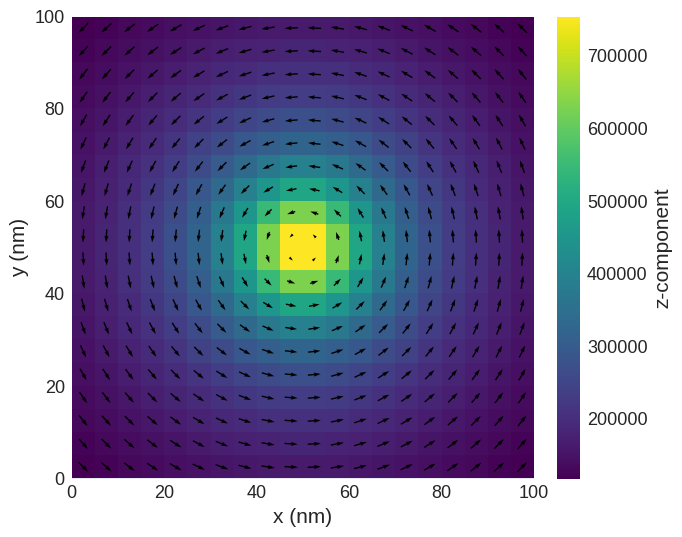

In [6]:
def m_vortex(pos):
    x, y, z = pos[0]/1e-9-50, pos[1]/1e-9-50, pos[2]/1e-9
    
    return (-y, x, 10)

system.m = df.Field(mesh, nvdim=3, value=m_vortex, norm=Ms)
system.m.sel(z=0).mpl()

**Dynamics:** In the first (relaxation) stage, we minimise the system's energy and therefore we do not need to specify the dynamics equation.

**Minimisation:** Now, we minimise the system's energy using `MinDriver`.

In [7]:
md = oc.MinDriver()
md.drive(system)

Running OOMMF (ExeOOMMFRunner)[2023/10/23 16:03]... (0.4 s)


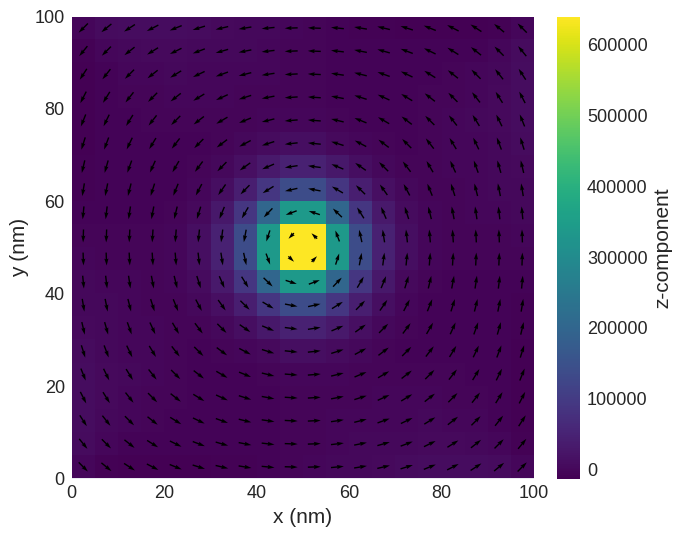

In [8]:
system.m.sel(z=0).mpl()

## Spin-polarised current

In the second part of simulation, we need to specify the dynamics equation for the system.

In [9]:
system.dynamics += mm.Precession(gamma0=gamma0) + mm.Damping(alpha=alpha) + mm.ZhangLi(u=ux, beta=beta)
system.dynamics

Precession(gamma0=221100.0) + Damping(alpha=0.1) + ZhangLi(u=-72.35, beta=0.05)

Now, we can drive the system for $8 \,\text{ns}$ and save the magnetisation in $n=100$ steps.

In [10]:
td = oc.TimeDriver()
td.drive(system, t=8e-9, n=100)

Running OOMMF (ExeOOMMFRunner)[2023/10/23 16:03]... (7.6 s)


The vortex after $8 \,\text{ns}$ is now displaced from the centre.

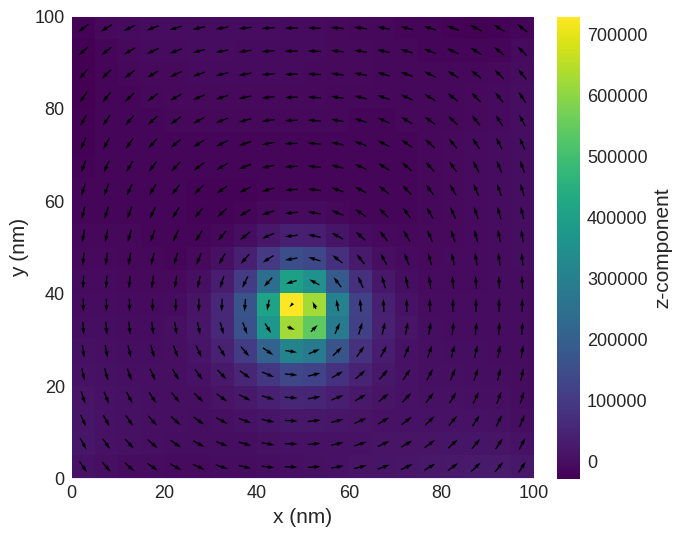

In [11]:
system.m.sel(z=0).mpl()

<Axes: xlabel='t'>

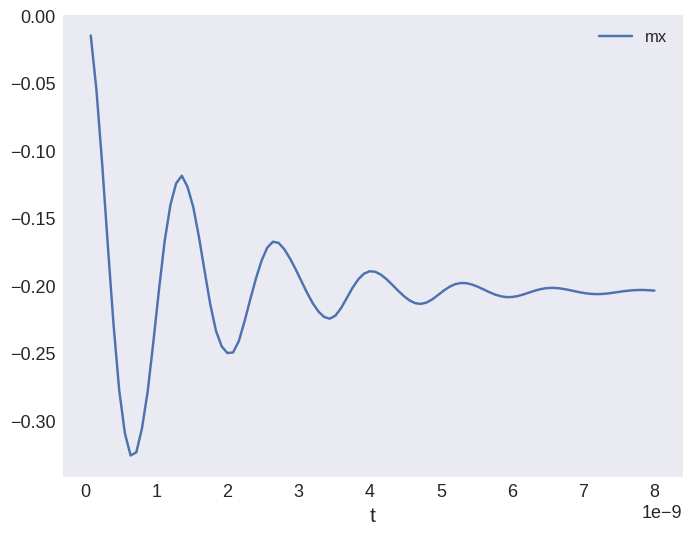

In [12]:
system.table.data.plot('t', 'mx')

## References

[1] µMAG Site Directory: http://www.ctcms.nist.gov/~rdm/mumag.org.html